# Before you begin


1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


### Provide your credentials to the runtime

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


# Use BigQuery via magics

The `google.cloud.bigquery` library also includes a magic command which runs a query and either displays the result or saves it to a variable as a `DataFrame`.

In [2]:
# Display query output immediately

%%bigquery --project yourproyectID
SELECT 
  COUNT(*) as total_rows
FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_stations`

,total_rows
0,98


In [3]:
# Save output in a variable `df`

%%bigquery df --project yourproyectID
SELECT 
  *
FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_trips`
WHERE
    EXTRACT(YEAR FROM start_time) = 2018

In [4]:
df

,trip_id,subscriber_type,bikeid,start_time,start_station_id,start_station_name,end_station_id,end_station_name,duration_minutes
0,16551987,None,854,2018-01-01 12:10:35+00:00,3660.0,Medina & East 6th,3660,Medina & East 6th,0
1,16553826,None,105,2018-01-02 14:19:33+00:00,2568.0,East 11th St. at Victory Grill,2568,East 11th St. at Victory Grill,0
2,16555289,None,955,2018-01-03 10:38:31+00:00,2823.0,Capital Metro HQ - East 5th at Broadway,2823,Capital Metro HQ - East 5th at Broadway,0
3,16555760,None,252,2018-01-03 13:38:44+00:00,3660.0,Medina & East 6th,3660,Medina & East 6th,0
4,16556248,Walk Up,484,2018-01-03 15:41:10+00:00,3685.0,Henderson & 9th,3685,Henderson & 9th,65
...,...,...,...,...,...,...,...,...,...
390483,19089146,U.T. Student Membership,712,2018-12-12 20:56:26+00:00,3838.0,Nueces & 26th,3841,23rd & Rio Grande,4
390484,19059877,U.T. Student Membership,546,2018-12-03 21:00:11+00:00,3838.0,Nueces & 26th,3841,23rd & Rio Grande,2
390485,19085018,U.T. Student Membership,513,2018-12-11 18:19:04+00:00,3838.0,Nueces & 26th,3841,23rd & Rio Grande,4
390486,19063575,U.T. Student Membership,3281,2018-12-04 20:28:40+00:00,3838.0,Nueces & 26th,3841,23rd & Rio Grande,3


### Declare the Cloud project ID which will be used throughout this notebook

In [5]:
# Replace proyect id with your own

project_id = 'yourproyectID'

### Combined table information

In [6]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

query_job = client.query('''
  SELECT
    start_station_name,
    EXTRACT(HOUR FROM start_time) AS start_hour,
    EXTRACT(DAYOFWEEK FROM start_time) AS day_of_week,
    duration_minutes
FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_trips` AS trips
JOIN
    `bigquery-public-data.austin_bikeshare.bikeshare_stations` AS stations
ON
    trips.start_station_name = stations.name
WHERE
    EXTRACT(YEAR FROM start_time) = 2018
    AND duration_minutes > 0
''')

results = query_job.result()  # Waits for job to complete.

print('Job has finished returning all rows on computed table')

Job has finished returning all rows on computed table


In [7]:
# Convert it to a local Pandas Dataframe

df = results.to_dataframe()

### Describe data

In [8]:
df.describe()

,start_hour,day_of_week,duration_minutes
count,380346.000000,380346.000000,380346.000000
mean,14.416297,4.087788,24.466181
std,5.168789,1.999890,95.693504
min,0.000000,1.000000,1.000000
25%,11.000000,2.000000,5.000000
50%,15.000000,4.000000,8.000000
75%,18.000000,6.000000,20.000000
max,23.000000,7.000000,12496.000000


### View the first 10 rows

In [9]:
df.head(10)

,start_station_name,start_hour,day_of_week,duration_minutes
0,Medina & East 6th,4,2,7
1,Lavaca & 6th,4,1,32
2,Lavaca & 6th,4,1,32
3,Lavaca & 6th,5,2,54
4,Lavaca & 6th,5,2,54
5,Lavaca & 6th,4,2,3
6,Lavaca & 6th,4,2,3
7,Lavaca & 6th,4,2,2
8,Lavaca & 6th,4,2,2
9,East 11th St. at Victory Grill,4,1,100


In [10]:
# 10 longest trips

df.sort_values('duration_minutes', ascending=False).head(10)[['start_station_name', 'start_hour', 'day_of_week', 'duration_minutes']]

,start_station_name,start_hour,day_of_week,duration_minutes
323270,City Hall / Lavaca & 2nd,20,3,12496
217808,2nd & Congress,16,7,9562
244345,Congress & Cesar Chavez,17,3,8305
341526,South Congress & Barton Springs at the Austin ...,21,7,7989
282068,21st & University,18,6,6832
372747,22nd & Pearl,23,6,6651
370114,23rd & Rio Grande,23,6,6643
378381,Convention Center / 3rd & Trinity,23,6,6640
19729,Trinity & 6th Street,3,6,6405
217214,Barton Springs @ Kinney Ave,16,7,5673


# Using BigQueryML

Lets train model but instead of bringing all information to Colab, directly onto BigQuery thanks to BigQueryML.

In [11]:
query_job = client.query('''
  CREATE OR REPLACE MODEL deusto.location_model
  OPTIONS
    (model_type='linear_reg', labels=['duration_minutes']) AS
  SELECT
    start_station_name,
    EXTRACT(HOUR FROM start_time) AS start_hour,
    EXTRACT(DAYOFWEEK FROM start_time) AS day_of_week,
    duration_minutes
FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_trips` AS trips
JOIN
    `bigquery-public-data.austin_bikeshare.bikeshare_stations` AS stations
ON
    trips.start_station_name = stations.name
WHERE
    EXTRACT(YEAR FROM start_time) = 2018
    AND duration_minutes > 0
''')

results = query_job.result()  # Waits for job to complete.

Done! Lets check how it went. We could use the evaluate function to test it against 2019 data.

In [12]:
query_job = client.query('''
    SELECT
      *
    FROM
      ML.EVALUATE(MODEL deusto.location_model, (
      SELECT
        start_station_name,
        EXTRACT(HOUR FROM start_time) AS start_hour,
        EXTRACT(DAYOFWEEK FROM start_time) AS day_of_week,
        duration_minutes
      FROM
        `bigquery-public-data.austin_bikeshare.bikeshare_trips` AS trips
      JOIN
      `bigquery-public-data.austin_bikeshare.bikeshare_stations` AS stations
      ON
        trips.start_station_name = stations.name
      WHERE EXTRACT(YEAR FROM start_time) = 2019)
    )
''')

results = query_job.result()  # Waits for job to complete.
metrics_df = results.to_dataframe()

In [13]:
metrics_df[['mean_absolute_error']]

,mean_absolute_error
0,42.161465


Or simply check its predictions, storing them as a table and comparing both predicted and real data.

In [14]:
query_job = client.query('''
CREATE OR REPLACE TABLE deusto.predicitons AS
    SELECT
      *
    FROM
      ML.PREDICT(MODEL deusto.location_model, (
      SELECT
        start_station_name,
        EXTRACT(HOUR FROM start_time) AS start_hour,
        EXTRACT(DAYOFWEEK FROM start_time) AS day_of_week,
        duration_minutes
      FROM
        `bigquery-public-data.austin_bikeshare.bikeshare_trips` AS trips
      JOIN
      `bigquery-public-data.austin_bikeshare.bikeshare_stations` AS stations
      ON
        trips.start_station_name = stations.name
      WHERE EXTRACT(YEAR FROM start_time) = 2019)
    )
''')

results = query_job.result()  # Waits for job to complete.

In [15]:
query_job = client.query('''
    SELECT
      *
    FROM
      deusto.predicitons
''')

results = query_job.result()  # Waits for job to complete.
prediction_df = results.to_dataframe()

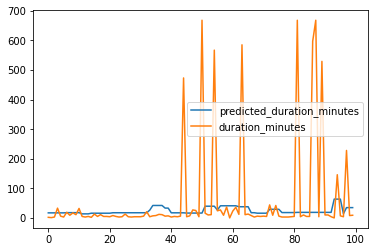

In [16]:
import matplotlib.pyplot as plt
 
prediction_df[['predicted_duration_minutes','duration_minutes']].head(100).plot()